# Lab ML for Data Science: Part II   
# Getting Insights into Quantum-Chemical Relations

In this project, we aim to extract quantum-chemical insights from a dataset of organic molecules. Firstly, we will visualize molecular structures and their properties for an overall understanding of their structure.
Following this, we aim to understand the relationship between the geometry of a molecule and its electronic properties, focusing on atomization energy. Atomization energy is the energy required to dissociate a molecule into its individual atoms, which is an important property for understanding chemical stability and reactivity.
We will use ML algorithm to model this relationship and predict atomization energy based on molecular structure.

In [1]:
import numpy as np
import pandas as pd 
import scipy.io
import time
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.spatial import distance_matrix
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

/Users/sonamehdizade/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sonamehdizade/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df = scipy.io.loadmat('qm7.mat')

#### About the dataset
The QM7 dataset contains 7165 organic molecules, each composed of up to 23 atoms. It includes:
- `R`: 3D coordinates of each atom in each molecule.
- `Z`: Atomic numbers of the atoms in each molecule.
- `T`: Atomization energies of the molecules, computed via quantum-chemical simulations.

In [3]:
df['R']  #3d Coordinates of each atom in each molecule

array([[[ 1.8864380e+00, -4.6487264e-03, -8.2392059e-03],
        [ 3.9499245e+00, -4.5920345e-03,  7.8234663e-03],
        [ 1.1976895e+00,  1.9404842e+00,  7.8234663e-03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 1.8973607e+00, -5.5746920e-03, -1.2094247e-02],
        [ 4.7544756e+00, -1.3265877e-02,  1.1149384e-03],
        [ 1.1760710e+00,  1.9320560e+00, -3.0991510e-03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 1.8692415e+00,  1.8897261e-04,  0.0000000e+00],
        [ 4.3934622e+00, -3.2125344e-04, -0.0000000e+00],
        [ 8.1146729e-01,  1.7577099e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0

In [4]:
df['R'].shape #7165 molecules, each consist of 23 atoms with 3d coordinates

(7165, 23, 3)

In [5]:
df['Z']

array([[6., 1., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       ...,
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.]], dtype=float32)

In [6]:
df['Z'].shape # for each molecule, the atomic number of atom types inside it 

(7165, 23)

Z: This is a 2D array of size 7165×23. It contains the atomic numbers for each atom in each molecule. The atomic numbers represent the type of atom:

1: Hydrogen (H)<br>
6: Carbon (C)<br>
7: Nitrogen (N)<br>
8: Oxygen (O)<br>
16: Sulfur (S)<br>
0: No atom at this position<br>

In [7]:
df['T']

array([[ -417.96,  -712.42,  -564.21, ..., -1662.1 , -1782.01, -1919.  ]],
      dtype=float32)

In [8]:
df['T'].shape

(1, 7165)

T: This is a 1D array of size 7165. It contains the atomization energies for each molecule, which have been computed via quantum-chemical simulations.

In [9]:
R = df['R']  # 3D coordinates of atoms
Z = df['Z']  # Atomic numbers 
T = df['T'].flatten()  # Atomization energies

### 1.1 Visualizing Molecules

Now, we create visualizations for molecules to better understand their structure:
- **2D Visualization**: Plotting the molecules in 2D using the x and y coordinates of atoms.
- **3D Visualization**: Plotting the molecules in 3D using the full 3D coordinates.

In [10]:
#mapping of atomic numbers to type for visualization purposes
atomic_symbols = {
    1: 'H',
    6: 'C',
    7: 'N',
    8: 'O',
    16: 'S'
}

Firstly, the function is created to visualize the 2D structure of a single molecule based on its atomic coordinates and types.

In [11]:
# Function to visualize a single molecule in 2D
def plot_single_molecule_2d(coordinates, atom_types, idx, threshold):
    # Extracting atomic numbers and coordinates for the specified molecule at index idx
    atomic_numbers = atom_types[idx]
    coordinates = coordinates[idx]

    # Filtering out atoms that are not present (atomic number= 0)
    is_present = atomic_numbers > 0
    coordinates = coordinates[is_present]
    
    # Extracting xy-coordinates
    xy_coordinates = coordinates[:, :2]
    distances = distance_matrix(coordinates, coordinates)
    
    atomic_numbers_for_mol = atomic_numbers[is_present]
    # Mapping atomic numbers to symbols
    atomic_symbols_for_mol = [atomic_symbols[num] for num in atomic_numbers_for_mol]

    # color mapping for plotting atomic types in different colors based on type
    color_mapping = {
        'C': '#ff9999',
        'N': '#ffb3e6',
        'O': '#add8e6',
        'H':'#b3ffb3',
        'S':'pink'
    }

    plt.figure(figsize=(12, 10))

    # Plotting each atom with its corresponding color
    for i, (x, y) in enumerate(xy_coordinates):
        atom_symbol = atomic_symbols_for_mol[i]
        color = color_mapping.get(atom_symbol, 'gray')
        plt.scatter(x, y, color=color, marker='o', s=2000, edgecolor="black")
        plt.text(x, y, atom_symbol, fontsize=24, horizontalalignment='center', color='black')

    # Drawing lines between pairs of atoms in molecule having distance below the threshold
    for j in range(len(xy_coordinates)):
        for k in range(j + 1, len(xy_coordinates)):
            if distances[j, k] < threshold:
                plt.plot([xy_coordinates[j, 0], xy_coordinates[k, 0]], 
                         [xy_coordinates[j, 1], xy_coordinates[k, 1]], 
                         'black', lw=1)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Molecule at index {idx} in 2d')
    plt.show()

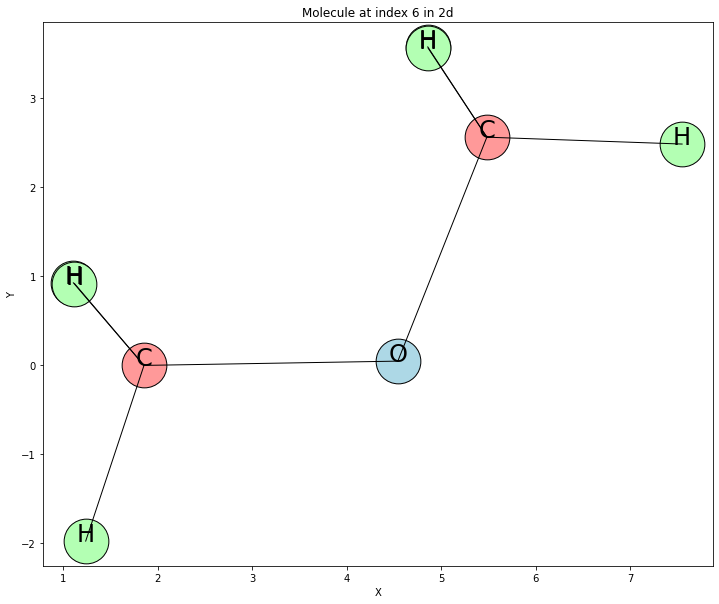

In [12]:
th=3
idx=6
plot_single_molecule_2d(R, Z, idx, th)

Similar visualization, now in 3D coordinate system.

In [13]:
# Function to visualize a single molecule in 3D
def plot_single_molecule_3d(coordinates, atom_types, idx, threshold):
    coordinates = coordinates[idx]
    atomic_numbers = atom_types[idx]

    is_present = atomic_numbers > 0
    coordinates = coordinates[is_present]
    atomic_numbers = atomic_numbers[is_present]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], s=500, alpha=0.5, edgecolors='b', color="#add8e6")
    
    #Calculating distances between atoms within mol and 
    #drawing bonds between atoms that are within the threshold distance.
    dist = distance_matrix(coordinates, coordinates)
    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            if dist[i, j] < threshold:
                ax.plot([coordinates[i, 0], coordinates[j, 0]], 
                        [coordinates[i, 1], coordinates[j, 1]], 
                        [coordinates[i, 2], coordinates[j, 2]], color='r')

    # Annotating atoms with atomic symbols
    for i, (x, y, z) in enumerate(coordinates):
        ax.text(x, y, z, atomic_symbols[atomic_numbers[i]], fontsize=14, horizontalalignment='center')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Molecule at index {idx}')
    plt.show()

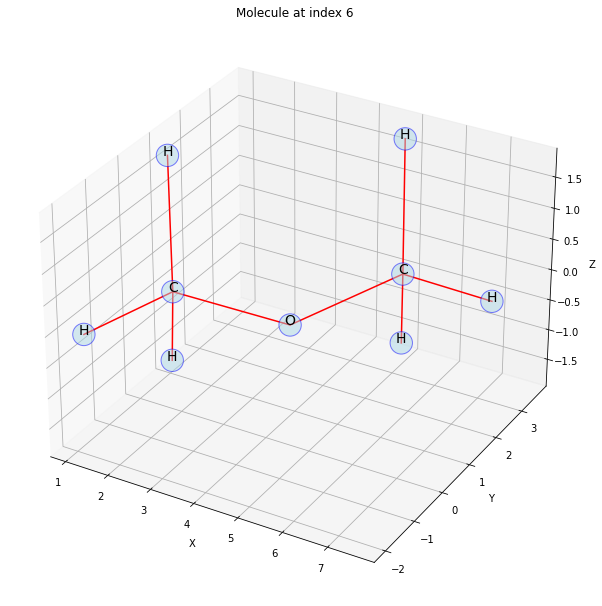

In [14]:
idx = 6
thr = 3
plot_single_molecule_3d(R, Z, idx, thr)

# 2. Data Representation, ML Model and Explanations
### 2.1 Model with Simple atom-based Representation

In [15]:
# Atomic number to one-hot vector mapping
atomic_numbers=np.array(list(atomic_symbols.keys()))

In [16]:
def get_molecule_representation(atom_numbers):
    molecule_representation = np.zeros(len(atomic_numbers))
    for atom_number in atom_numbers:
        if atom_number > 0:
            molecule_representation[np.where(atomic_numbers == atom_number)] +=1
    return molecule_representation

In [17]:
#testing for molecule at idx=1
print(get_molecule_representation(Z[1]))

[6. 2. 0. 0. 0.]


In [18]:
X = np.array([get_molecule_representation(Z[i]) for i in range(Z.shape[0])])
y = T

In [19]:
X

array([[ 4.,  1.,  0.,  0.,  0.],
       [ 6.,  2.,  0.,  0.,  0.],
       [ 4.,  2.,  0.,  0.,  0.],
       ...,
       [ 9.,  6.,  1.,  0.,  0.],
       [10.,  7.,  0.,  0.,  0.],
       [12.,  7.,  0.,  0.,  0.]])

In [20]:
print(X.shape, y.shape)

(7165, 5) (7165,)


#### Splitting into train, validation and test sets
We firstly need to understand the distribution of this target variable to ensure that our data splits (training, validation, and test sets) accurately represent the entire dataset.

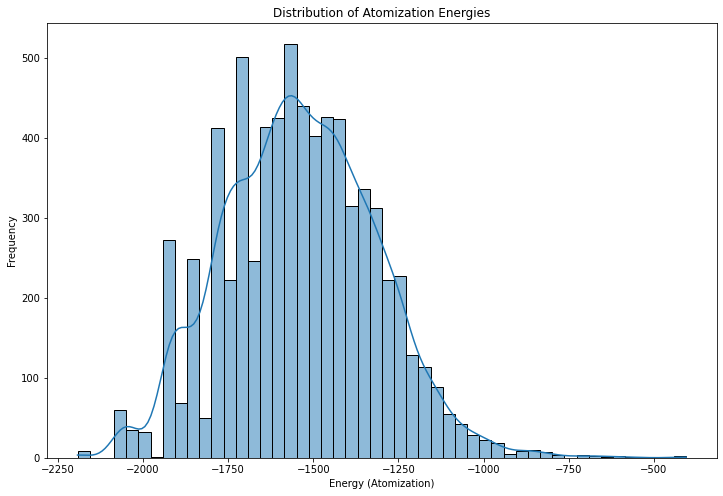

In [21]:
# Plot the distribution of energy values
plt.figure(figsize=(12, 8))
sns.histplot(y, bins=50, kde=True)
plt.xlabel('Energy (Atomization)')
plt.ylabel('Frequency')
plt.title('Distribution of Atomization Energies')
plt.show()

The histogram above shows that the distribution of energy values approximately follows a bell curve. However, there are some indications of skewness and possible multimodal characteristics.

Now, we will firstly present the distribution of the atomization energies in the train, validation, and test sets using random splitting:

In [22]:
#data is splitted as 60%, 20%, 20% for train, test, validation randomly
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

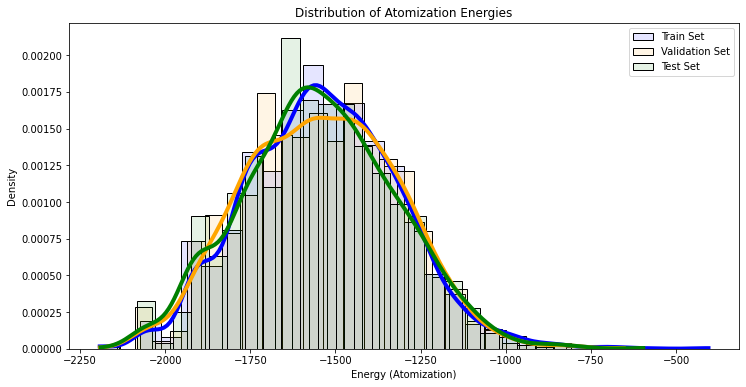

In [23]:
def plot_distribution_of_sets(y_train, y_val, y_test):
    # Plot the distribution of atomization energies in the train, validation, and test sets
    plt.figure(figsize=(12, 6))

    # Plotting the distributions with light colors for histograms and dark, thick KDE lines for better observations
    sns.histplot(y_train, bins=30, kde=True, color='blue', label='Train Set', stat='density', alpha=0.10,
                 line_kws={'color': 'darkblue', 'linewidth': 4})
    sns.histplot(y_val, bins=30, kde=True, color='orange', label='Validation Set', stat='density', alpha=0.10,
                 line_kws={'color': 'darkorange', 'linewidth': 4})
    sns.histplot(y_test, bins=30, kde=True, color='green', label='Test Set', stat='density', alpha=0.10,
                 line_kws={'color': 'darkgreen', 'linewidth': 4})

    plt.xlabel('Energy (Atomization)')
    plt.ylabel('Density')
    plt.title('Distribution of Atomization Energies')
    plt.legend()
    plt.show()
plot_distribution_of_sets(y_train, y_val, y_test)

From the plot above, we can observe variations between the distributions of the train, validation, and test sets when using random splitting. This inconsistency can lead to biased model evaluation.

#### Stratified Splitting application

To address the variations in the distributions, we will apply stratified splitting to ensure that the atomization energy distribution is similar across the train, validation, and test sets.

This is particularly important because it provides **evaluation fairness** by ensuring that the test set is a representative sample of the entire dataset, providing a fair evaluation of the model's performance.
Moreover, it helps **to avoid bias** by preventing any subset of the data (train, validation, test) from having an imbalanced distribution of the target variable, which could bias the model.

In [24]:
# Binning the continuous target variable
y_binned = pd.qcut(y, q=15, labels=False)


# Function to perform stratified splitting using StratifiedKFold
def stratified_split(X, y, y_binned):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    splits = list(skf.split(X, y_binned))
    
    #first split for test set
    train_val_index, test_index = splits[0]
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]
    y_binned_train_val = y_binned[train_val_index]
    #print(np.unique(y_binned_train_val, return_counts=True))
    
    #second split for validation set
    skf_val = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    train_index, val_index = next(skf_val.split(X_train_val, y_binned_train_val))
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]
    return X_train, X_val, X_test, y_train, y_val, y_test, X_train_val, y_train_val


X_train, X_val, X_test, y_train, y_val, y_test, X_train_val, y_train_val = stratified_split(X, y, y_binned)

In [25]:
#train-val-test sizes
print(f"Train size:\t{X_train.shape[0]:>2}")
print(f"Val  size:\t{X_val.shape[0]:>2}")
print(f"Test size:\t{X_test.shape[0]:>2}")

Train size:	4299
Val  size:	1433
Test size:	1433


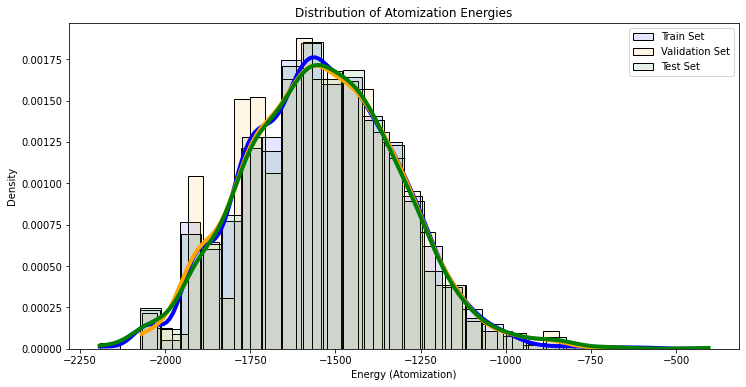

In [26]:
# Plot the distribution of atomization energies in the train, validation, and test sets after stratified splitting
plot_distribution_of_sets(y_train, y_val, y_test)

From the plot above, we can observe that the distributions of the atomization energies in the train, validation, and test sets are much more similar when using stratified splitting compared to random splitting. 

In [27]:
#Centering of data 

# Computing the mean of the training data
X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

# Centering the training data
X_train_centered = X_train - X_train_mean
y_train_centered = y_train - y_train_mean

# Centering the validation data using the training mean
X_val_centered = X_val - X_train_mean
y_val_centered = y_val - y_train_mean

In [28]:
# Function to evaluate the model with given parameters and determine the best resulting in min MAE
def select_best_lambda(X_train, y_train, X_val, y_val, lambdas):
    mae_values = []
    for l in lambdas:
        ridge_reg = Ridge(alpha=l)
        ridge_reg.fit(X_train, y_train)
        y_pred_val = ridge_reg.predict(X_val)
        mae_val = mean_absolute_error(y_val, y_pred_val)
        mae_values.append(mae_val)

    best_lambda_idx = np.argmin(np.array(mae_values))
    best_lambda = lambdas[best_lambda_idx]
    best_mae = mae_values[best_lambda_idx]

    return best_lambda, best_mae

In [29]:
lambdas = np.logspace(-5, 5, 200)  #evenly spaced numbers on log scale  between 10^-5 and 10^5
best_lambda,best_mae=select_best_lambda(X_train_centered, y_train_centered, X_val_centered, y_val_centered, lambdas)

In [30]:
print(f"Best lambda: {best_lambda}")
print(f"Best MAE: {best_mae:.2f}")

Best lambda: 1e-05
Best MAE: 15.86


Then, with the best value of lambda selected, we build the final model on train+validation set and evaluate it on test set.

In [31]:
# Centering the train+val and test data using the mean value
X_train_val_mean=X_train_val.mean(axis=0)
y_train_val_mean=y_train_val.mean()
X_train_val_centered = X_train_val - X_train_val_mean
y_train_val_centered = y_train_val -y_train_val_mean
X_test_centered = X_test - X_train_val_mean
y_test_centered = y_test - y_train_val_mean

In [32]:
#training  final model with best lambda on train+val dataset  
ridge_reg_final = Ridge(alpha=best_lambda)
ridge_reg_final.fit(X_train_val_centered, y_train_val_centered) 
y_pred_test = ridge_reg_final.predict(X_test_centered)

In [33]:
test_error=mean_absolute_error(y_test_centered,y_pred_test)
print(f"MAE on test data: {test_error:.2f}")

MAE on test data: 15.32


In [34]:
w = ridge_reg_final.coef_
intercept = ridge_reg_final.intercept_

print(f"Final Model Weights: {w}")
print(f"Final Model Intercept: {intercept}")

Final Model Weights: [ -68.76484816 -157.33561754 -102.22907815 -101.2284998   -80.0589489 ]
Final Model Intercept: 9.876152508587976e-05


### XAI on Simple atom-based model

The atomization energy is typically a negative quantity because forming a molecule is energetically favorable compared to separating it into individual atoms. Essentially, the atomization energy represents the energy required to break all the bonds in a compound and separate its atoms infinitely far apart. Therefore, it is often viewed as the negative of the energy released during molecule formation.

We firstly plot the weights per atom type to visually understand which atom types have the most significant impact on the prediction of atomization energy.

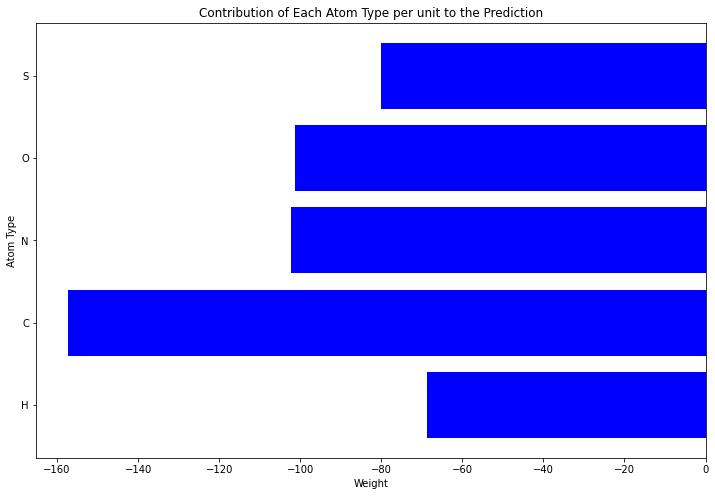

In [35]:
atom_labels=list(atomic_symbols.values())
# Plotting the weights as a bar plot
plt.figure(figsize=(12, 8))
plt.barh(atom_labels, w, color='blue')
plt.xlabel('Weight')
plt.ylabel('Atom Type')
plt.title('Contribution of Each Atom Type per unit to the Prediction')
plt.show()

From the graph above we clearly see that, Carbon (C) has the most significant negative weight at -157.34, suggesting it strongly lowers the atomization energy and plays a crucial role in stabilizing the molecule. Nitrogen (N) and Oxygen (O) have weights of -102.23 and -101.23, respectively, indicating they also significantly reduce the atomization energy, with similar influences. Sulfur (S) has a moderate negative weight of -80.06, while Hydrogen (H) has the smallest negative weight at -68.76, indicating it has the least impact on lowering the atomization energy compared to other atoms. Overall, C contributes the most to stabilizing the molecule, followed by N, O, S, and H.

In [36]:
# explanations
def explain_prediction(molecule_representation, w):
    explanations = {}
    for i, atom_type in enumerate(atom_labels):
        contribution = w[i] * molecule_representation[i]
        explanations[atom_type] = contribution
    return explanations

In [37]:
#normalized version by total contribution
def explain_prediction_normalized(molecule_representation, w):
    explanations = {}
    total_contribution = np.sum(w * molecule_representation)
    for i, atom_type in enumerate(atom_labels):
        contribution = w[i] * molecule_representation[i]
        normalized_contribution = contribution / total_contribution
        explanations[atom_type] = normalized_contribution
    return explanations

In [38]:
# Function to plot contributions to total energy by atom types
def plot_contributions(molecule_idx, molecule_representation, explanations):
    atom_labelss = [f"{atom_type}({int(molecule_representation[i])})" for i, atom_type in enumerate(atom_labels)]
    contributions = [explanations[atom_type] for atom_type in atom_labels]
    
    total_energy = np.sum(contributions)

    plt.figure(figsize=(12, 8))
    plt.barh(atom_labelss, contributions, color='red')
    plt.xlabel('Contribution to Atomization Energy')
    plt.ylabel('Atom Type (Count)')
    plt.title(f'Contributions of Each Atom Type to Predicted Atomization Energy of Molecule {molecule_idx}')

    # Adding the total energy as legend
    textstr = f'Total: {total_energy:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
                   verticalalignment='top', horizontalalignment='right', bbox=props)
    plt.show()

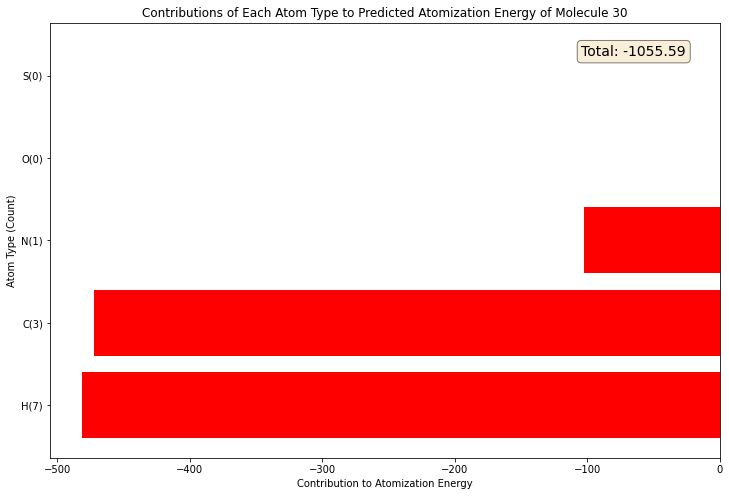

In [39]:
mol_idx = 30 
molecule_representation = get_molecule_representation(Z[mol_idx])
explanations = explain_prediction(molecule_representation, w)
plot_contributions(mol_idx, molecule_representation, explanations)

In [40]:
explanations

{'H': -481.3539371404677,
 'C': -472.0068526259191,
 'N': -102.22907815046672,
 'O': -0.0,
 'S': -0.0}

We see from the plot that hydrogen and carbon contribute significantly to the total prediction energy. Although there are more than twice as many hydrogen atoms (7) as carbon atoms in the molecule, their contributions are similar(-481.35 and -472.01) because the weight of carbon (-157.34) is much larger than that of hydrogen (-68.76).

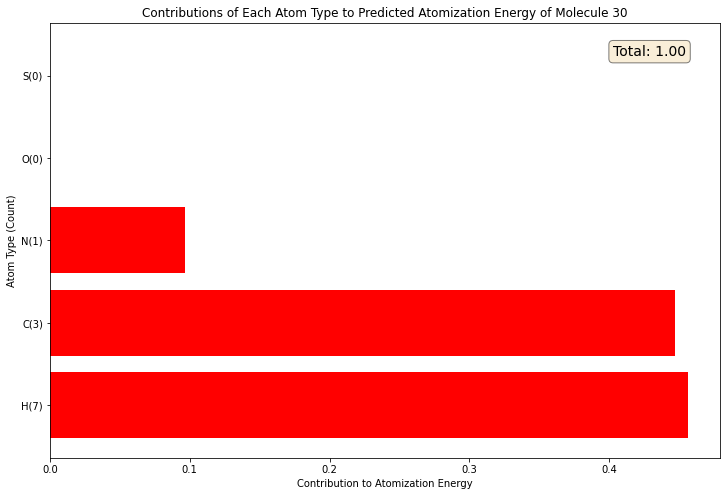

In [41]:
#normalized plot - which atom type constituted to which portion of total energy prediction
explanations_normalized = explain_prediction_normalized(molecule_representation, w)
plot_contributions(mol_idx, molecule_representation, explanations_normalized)

In [42]:
explanations_normalized

{'H': 0.45600469630349166,
 'C': 0.4471498514450482,
 'N': 0.0968454522514601,
 'O': 0.0,
 'S': 0.0}

In [43]:
# Simulating changing an atom type and explaining the new contributions
def simulate_atom_change_and_explain(molecule_representation, w, original_atom, new_atom):
    modified_representation = molecule_representation.copy()
    # Modifying molecule structure by changing atom type at first occurence to new atom type
    original_index = np.where(atomic_numbers == original_atom)[0][0]
    new_index = np.where(atomic_numbers == new_atom)[0][0]
    modified_representation[original_index] -= 1
    modified_representation[new_index] += 1
    
    new_explanations = explain_prediction(modified_representation, w)
    return new_explanations, modified_representation

# Plotting comparative contributions and total energy before and after atom type change
def plot_comparative_contributions(original_explanations, new_explanations, atomic_symbols, original_atom, new_atom, original_representation, modified_representation):
    atom_labels = [atomic_symbols[atom_type] for atom_type in atomic_numbers]
    original_contributions = [original_explanations[atom_type] for atom_type in atom_labels]
    new_contributions = [new_explanations[atom_type] for atom_type in atom_labels]

    x = np.arange(len(atom_labels)) 
    width = 0.35  

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, original_contributions, width, label=f'Original ({atomic_symbols[original_atom]})')
    ax.bar(x + width/2, new_contributions, width, label=f'New ({atomic_symbols[new_atom]})')

    original_total_energy = np.sum([original_explanations[atom_type] for atom_type in atom_labels]) #before mod
    new_total_energy = np.sum([new_explanations[atom_type] for atom_type in atom_labels]) #after modification

    ax.set_xlabel('Atom Type')
    ax.set_ylabel('Contribution to Atomization Energy')
    ax.set_title('Contributions Before and After Atom Type Change')
    ax.set_xticks(x)
    ax.set_xticklabels(atom_labels, rotation=45)
    ax.legend()

    # Adding the total energy change after modification
    textstr = f'Total Energy (Original): {original_total_energy:.2f}\nTotal Energy (New): {new_total_energy:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

    plt.show()

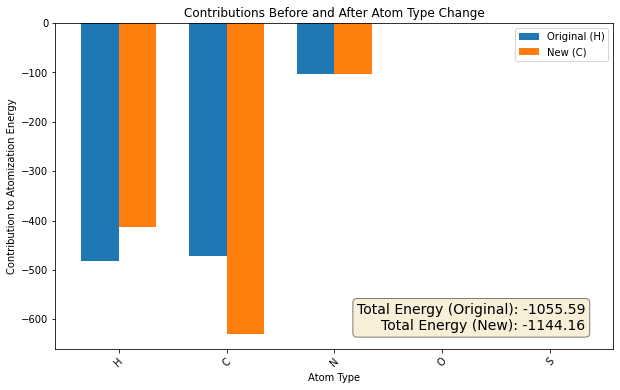

In [44]:
#simulating changing the type of one element in the given molecule from H to C
original_atom = 1  # H
new_atom = 6  # C
new_explanations, modified_representation = simulate_atom_change_and_explain(molecule_representation, w, original_atom, new_atom)
plot_comparative_contributions(explanations, new_explanations, atomic_symbols, original_atom, new_atom, molecule_representation, modified_representation)

We see from the graph that the contributions have shifted in favor of carbon when the molecule has 6 H and 4 C atoms. The total energy has changed from -1055.59 to -1144.16, indicating an increase in stability due to the higher contribution from Carbon.

**Comparison with chemical knowledge**

As explained above, the atomization energy of a molecule can be understood as the negative energy required to break the bonds and move the atoms infinitely far apart. The key to calculating this energy lies in the different bonds within the molecule, which are not represented in the model's input feature map, as we only account for the number of different atom types present in the molecule. Nevertheless, we can derive some chemical explanations from the XAI (Explainable AI) results obtained from the model. The following table shows the bond energies for different single bonds in kJ/mol.  

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
 & \textbf{C} & \textbf{H} & \textbf{N} & \textbf{O} & \textbf{S} \\ \hline\hline
\textbf{C} & 347 & 413 & 305 & 358 & 259 \\ \hline
\textbf{H} & 413 & 432 & 391 & 467 & 347 \\ \hline
\textbf{N} & 305 & 391 & 160 & 201 & Na  \\ \hline
\textbf{O} & 358 & 467 & 201 & 146 & Na  \\ \hline
\textbf{S} & 259 & 347 & Na  & Na  & 266 \\ \hline
\end{array}
$$

It is not immediately clear why the weight for carbon atoms is (negatively) higher than for hydrogen atoms, given that the average bond energies between hydrogen and any other atom are higher than for carbon atoms. One explanation can be derived by considering the number of bonds different atoms can form. Carbon typically forms four bonds with other atoms, whereas hydrogen forms only one, due to their different numbers of valence electrons. This suggests that the model assigns higher importance to a single carbon atom because it usually has at least four bonds, while a hydrogen atom typically has only one bonding partner. A similar explanation applies to the weights of nitrogen, oxygen, and sulfur.

Another factor that might result in higher weights for carbon atoms, followed by nitrogen and oxygen, is that these atom types often form multiple bonds, such as double and triple bonds. These bond energies are shown below.

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
 \textbf{C=C} & \textbf{C} \equiv \textbf{C} & \textbf{O=O} & \textbf{O=C} & \textbf{C} \equiv \textbf{O} & \textbf{N=O}
 & \textbf{N=N} & \textbf{N} \equiv \textbf{N} & \textbf{C}  \equiv \textbf{N} & \textbf{C=N} \\ \hline
614 & 839 & 495 & 745 & 1072 & 607 & 418 & 941 & 891 & 615 \\ \hline
\end{array}
$$

From the table, we can observe that the bond energies for multiple bonds are generally 2-3 times higher than for single bonds. This suggests that the average bond energy of bonds involving these atom types is higher than for the rest, which could explain their higher importance in the trained weights.

In summary, it can be said that the rules on which the model bases its decisions are partially chemically interpretable and valid. However, they cannot be considered true chemical reasoning, as the contribution to the atomization energies of molecules comes from the bonds between different atoms, not from the individual atom types alone.

### 2.2  Models with Pairs of Atoms

Considering mutual distance between atoms, we need to find bin range first. For binning, we need to firsly determine the range of pairwise distances between atoms.

In [45]:
def distance_range(R, Z):
    distances = []
    for i in range(len(R)):
        coordinates = R[i]
        atomic_numbers = Z[i]
        filtered_coordinates = coordinates[atomic_numbers > 0]  # Filtering out non-existent atoms
        
        # Calculatingg the distance matrix for the filtered coordinates
        dist_matrix = distance_matrix(filtered_coordinates, filtered_coordinates)
        
        # Extracting the upper triangular part of the distance matrix
        #to avoid redundant calculations and exclude the diagonal.
        dist_upper_tri = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
        distances.extend(dist_upper_tri) #concatenatin elements
        
    return np.array(distances)

In [46]:
pair_distances = distance_range(R, Z)

# Finding the min and max distances between atoms
min_dist, max_dist = np.min(pair_distances), np.max(pair_distances)
print(f"Min distance: {min_dist}, Max distance: {max_dist}")

Min distance: 1.8265360620743547, Max distance: 18.717450675317142


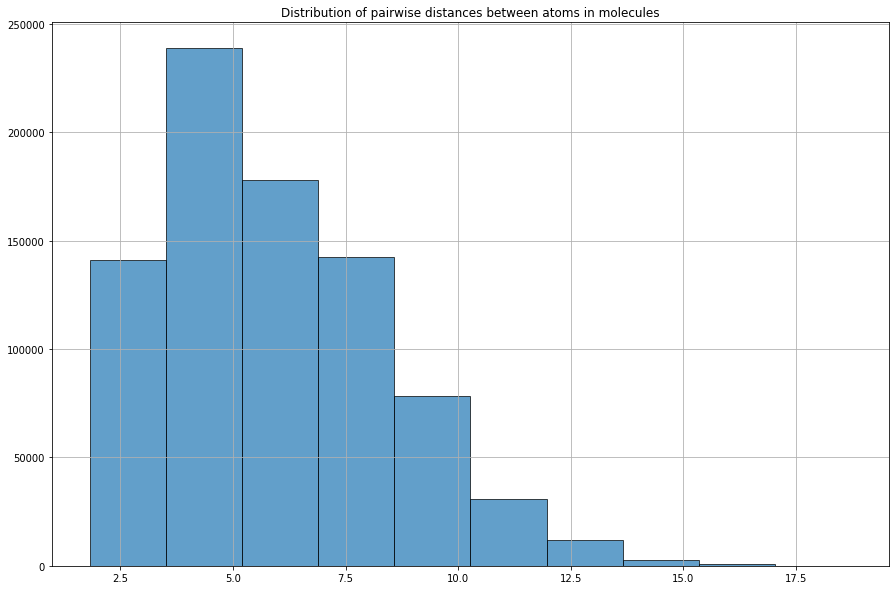

In [47]:
plt.figure(figsize=(15, 10))
plt.hist(pair_distances, bins=10, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of pairwise distances between atoms in molecules')
plt.grid(True)
plt.show()

In [48]:
#defining boundaries for binning
min_dist, max_dist=0, 21

In [49]:
#dividing distance into 10 bins
distance_bins = np.linspace(min_dist, max_dist, 11)
print(f"Distance bins: {distance_bins}")

Distance bins: [ 0.   2.1  4.2  6.3  8.4 10.5 12.6 14.7 16.8 18.9 21. ]


In [50]:
#finding centers of bins
bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2

In [51]:
bin_centers

array([ 1.05,  3.15,  5.25,  7.35,  9.45, 11.55, 13.65, 15.75, 17.85,
       19.95])

### Distance feature map for pairs

We define two distance based feature mapping functions to convert distances into feature vectors.The soft indicator uses a Gaussian function for smoother transitions.

In [52]:
#hard indicator function
def distance_fmap_hard(distance ,distance_bins):
    num_bins=len(distance_bins)-1
    features = np.zeros(num_bins)
    for i in range(num_bins):
        if distance_bins[i] <= distance < distance_bins[i + 1]:
            features[i] = 1
            break
    return features

In [53]:
d=distance_fmap_hard(10, distance_bins)
d

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [54]:
#soft indicator
def distance_fmap_soft(distance, bin_centers, sigma):
    def gaussian(x, mu, sigma):
        return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    features = np.array([gaussian(distance, mu, sigma) for mu in bin_centers])
    return features

In [55]:
#example of soft binning distance of 10 into predefined bins
distance_fmap_soft(10, bin_centers, 3)

array([0.01167695, 0.07376982, 0.28551171, 0.67696285, 0.98333487,
       0.87505178, 0.47704765, 0.15932557, 0.03259905, 0.0040862 ])

### Atom types pair representation

For atom type representation, unique pairs of atom types are generated, and then function is defined to create feature maps for these pairs as one-hot encoded vector.

In [56]:
unique_pairs = [(atomic_numbers[i], atomic_numbers[j]) for i in range(len(atomic_numbers)) for j in range(i, len(atomic_numbers))]

In [57]:
unique_pairs

[(1, 1),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 16),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 16),
 (7, 7),
 (7, 8),
 (7, 16),
 (8, 8),
 (8, 16),
 (16, 16)]

In [58]:
len(unique_pairs)

15

In [59]:
#function to create atom type feature map for pairs
def atom_type_fmap(an1, an2):
    feature = np.zeros(len(unique_pairs))
    pair = (min(an1, an2), max(an1, an2)) 
    if pair in unique_pairs:
        feature[unique_pairs.index(pair)] = 1
    return feature

In [60]:
#function to generate big feature map for pairs of atoms
def get_molecule_representation_pairs(r, z, bin_centers,sigma):
    molecule_representation = []
    
    for i in range(len(z)):
        for j in range(i + 1, len(z)):
            if z[i] > 0 and z[j] > 0:  # both positions have valid atoms
                distance = np.linalg.norm(r[i] - r[j])
                dist_fmap = distance_fmap_soft(distance, bin_centers, sigma)
                a_type_fmap = atom_type_fmap(z[i], z[j])
                
                #big feature map as outer product of 2 f-maps(atom type and distance based)
                combined_fmap = np.outer(dist_fmap, a_type_fmap).flatten()
                molecule_representation.append(combined_fmap)

    return np.sum(molecule_representation, axis=0)

### Determining the Best Number of Bins, Sigma Value, and Lambda

We use Grid Search to find the optimal combination of parameters (number of bins, sigma, and lambda) by testing all possible combinations and selecting the one that gives the lowest error.

In [61]:
# Grid search parameters
num_bins_list = [5,15, 20]
sigmas = [0.5, 1.0, 2.0]
lambdas = np.logspace(-5, 5, 50)

In [62]:
# Splitting data indices for train+val and test sets
X_train_val_indices, X_test_indices, y_train_val, y_test = train_test_split(np.arange(len(X)), y, test_size=0.2, random_state=42)

In [63]:
best_params = None
best_mae = float('inf')

for num_bins in num_bins_list:
    for sigma in sigmas:
        distance_bins = np.linspace(min_dist, max_dist, num_bins + 1)
        bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2

        # Creating pairwise feature representation for the training and validation data
        X_train_val_pairs = np.array([get_molecule_representation_pairs(R[i], Z[i], bin_centers, sigma) for i in X_train_val_indices])

        # Splitting train_val data into training and validation sets
        train_val_indices, val_indices = train_test_split(np.arange(len(X_train_val_pairs)), test_size=0.25, random_state=42)
        X_train, X_val = X_train_val_pairs[train_val_indices], X_train_val_pairs[val_indices]
        y_train, y_val = y_train_val[train_val_indices], y_train_val[val_indices]
        
        # Centering the training and validation data using the training mean
        X_train_mean = np.mean(X_train, axis=0)
        y_train_mean = np.mean(y_train)

        X_train_centered = X_train - X_train_mean
        y_train_centered = y_train - y_train_mean

        X_val_centered = X_val - X_train_mean
        y_val_centered = y_val - y_train_mean

        best_lambda, mae_val = select_best_lambda(X_train_centered, y_train_centered, X_val_centered, y_val_centered, lambdas)
        
        if mae_val < best_mae:
            best_mae = mae_val
            best_params = (num_bins, sigma, best_lambda)

print(f"Best parameters: num_bins = {best_params[0]}, sigma = {best_params[1]}, lambda = {best_params[2]}")
print(f"Best MAE on validation set: {best_mae}")

Best parameters: num_bins = 20, sigma = 0.5, lambda = 1e-05
Best MAE on validation set: 6.0749229911793705


#### Final model
The final model is trained using the optimal parameters found from the grid search. It is then evaluated on the test set to determine its performance.

In [64]:
# Retrieving best parameter values for final model 
best_num_bins, best_sigma, best_lambda = best_params

# Recomputing distance bins and bin centers with best size of intervals (number of bins)
distance_bins = np.linspace(min_dist, max_dist, best_num_bins + 1)
bin_centers = (distance_bins[:-1] + distance_bins[1:]) / 2

In [65]:
# Recomputing pairwise feature representation for the training and test data
X_train_val_pairs = np.array([get_molecule_representation_pairs(R[i], Z[i], bin_centers, best_sigma) for i in X_train_val_indices])
X_test_pairs = np.array([get_molecule_representation_pairs(R[i], Z[i], bin_centers, best_sigma) for i in X_test_indices])
y_train_val_pairs = y[X_train_val_indices]
y_test_pairs = y[X_test_indices]

# Centering the sets
X_train_val_mean2 = np.mean(X_train_val_pairs, axis=0)
y_train_val_mean2 = np.mean(y_train_val_pairs)

X_train_val_centered2 = X_train_val_pairs - X_train_val_mean2
y_train_val_centered2 = y_train_val_pairs - y_train_val_mean2

X_test_centered2 = X_test_pairs - X_train_val_mean2
y_test_centered2 = y_test_pairs - y_train_val_mean2

In [66]:
# Train the final model using the best lambda
final_model = Ridge(alpha=best_lambda)
final_model.fit(X_train_val_centered2, y_train_val_centered2)

# Evaluate the final model on the test data
y_pred_test2 = final_model.predict(X_test_centered2)
mae_test = mean_absolute_error(y_test_centered2, y_pred_test2)
print(f"Mean Absolute Error on Test Set: {mae_test:.2f}")

# Weights in the original space 
w2 = final_model.coef_
b2 = final_model.intercept_

Mean Absolute Error on Test Set: 6.33


In [67]:
i = 15
print(f"Final Model Weights (first {i} weights): {w2[:i]}")

Final Model Weights (first 15 weights): [ 1.25860050e+01  3.90572257e+03  8.18871264e+02  2.57885443e+03
 -9.55845947e-06  1.66448352e+04  2.30450143e+03 -1.19861910e+04
 -1.05532303e+00 -8.23113219e+02  3.43179091e+03 -1.67017822e-01
  2.47771446e-06 -4.34368084e+00  0.00000000e+00]


In [68]:
print(w2.shape)  #15 pairs x 20 bins

(300,)


### Explanations for Model with Pairs of Atoms (Pairwise Potentials)

In [69]:
# Function to plot pairwise potentials
def plot_pairwise_potentials(w, bin_centers):
    num_bins = len(bin_centers)
    
    #for each pair plotting the contribution vs distance
    for i, pair in enumerate(unique_pairs):
        
        #extarcting the weights (contributions) for the current pair 
        contributions = w2[i*num_bins:(i+1)*num_bins] 
        
        plt.figure(figsize=(12, 8))
        plt.plot(bin_centers, contributions, marker='o')
        plt.xlabel('Distance')
        plt.ylabel('Contribution to Atomization Energy')
        plt.title(f'Pairwise Potentials for {atomic_symbols[pair[0]]}-{atomic_symbols[pair[1]]}')
        
        plt.grid(True)
        plt.show()

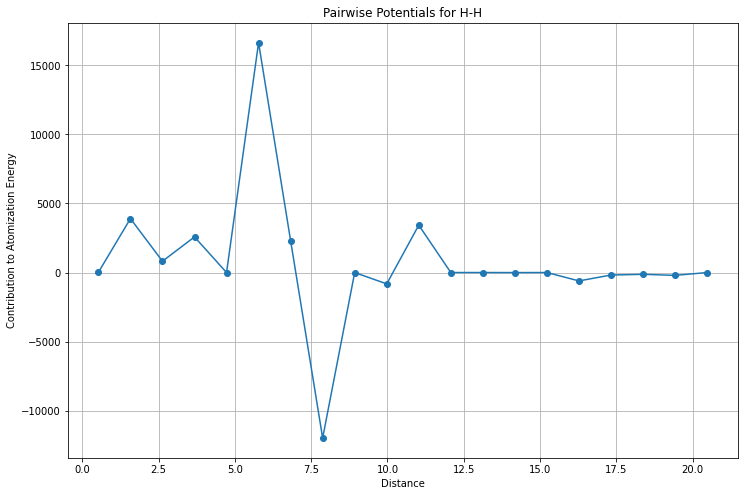

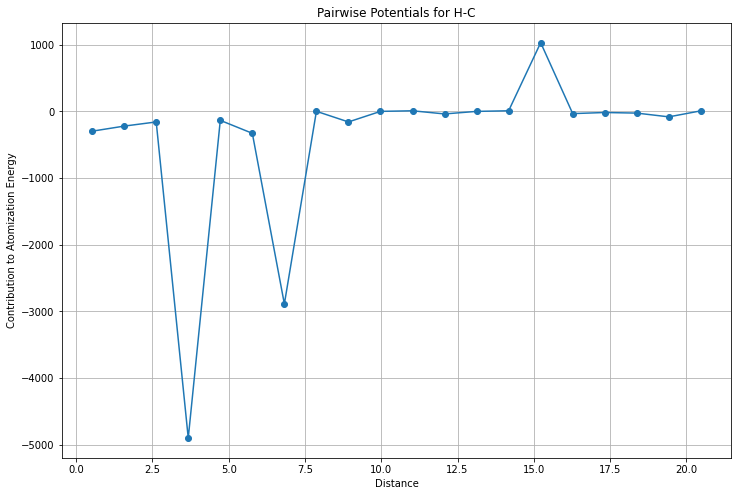

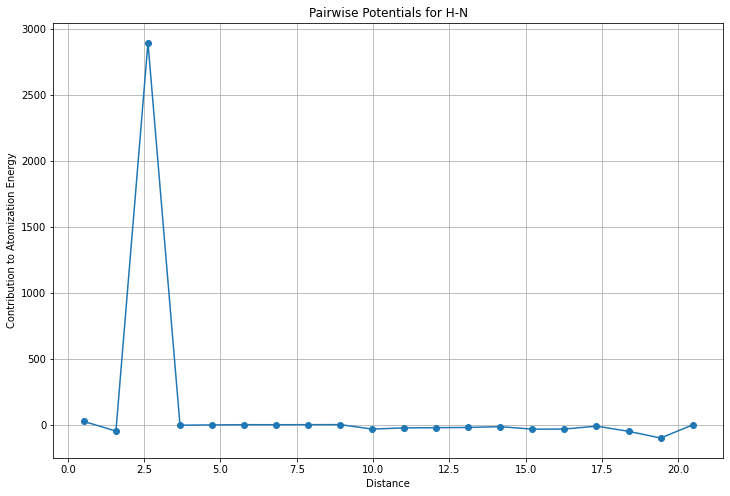

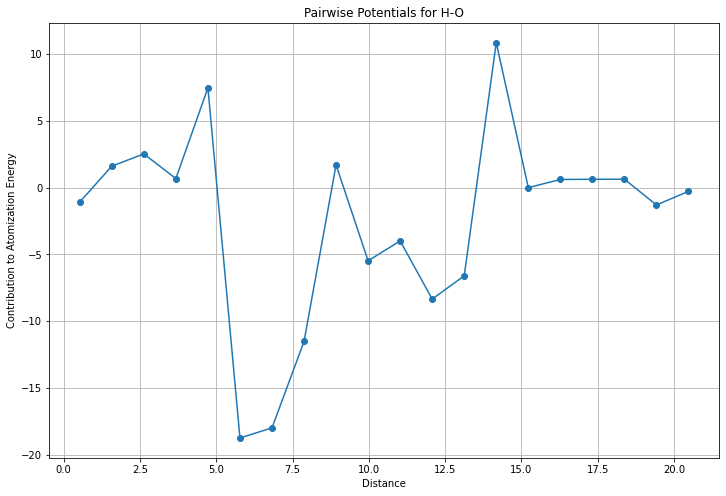

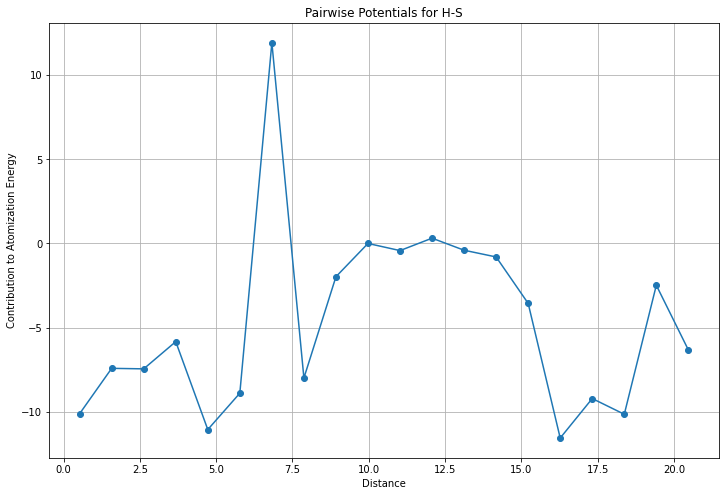

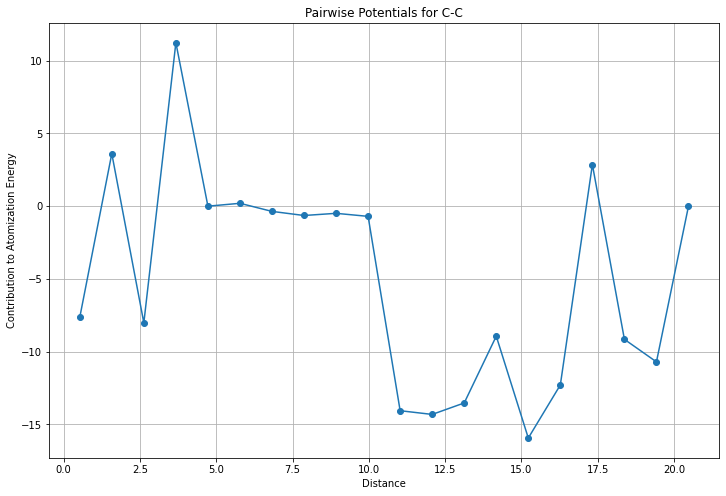

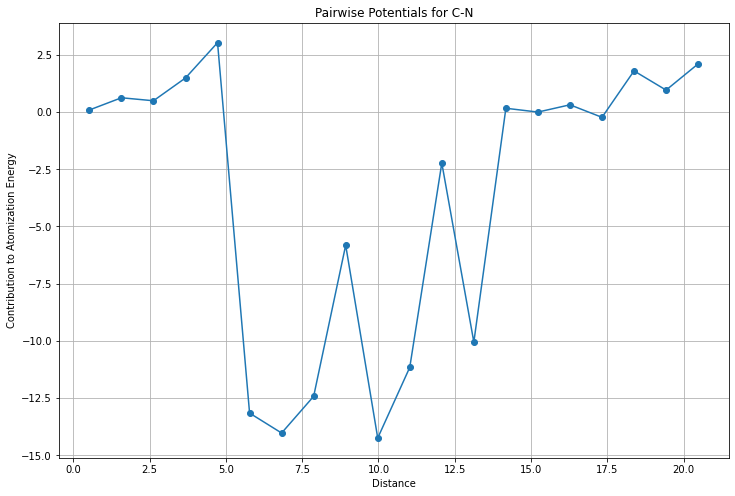

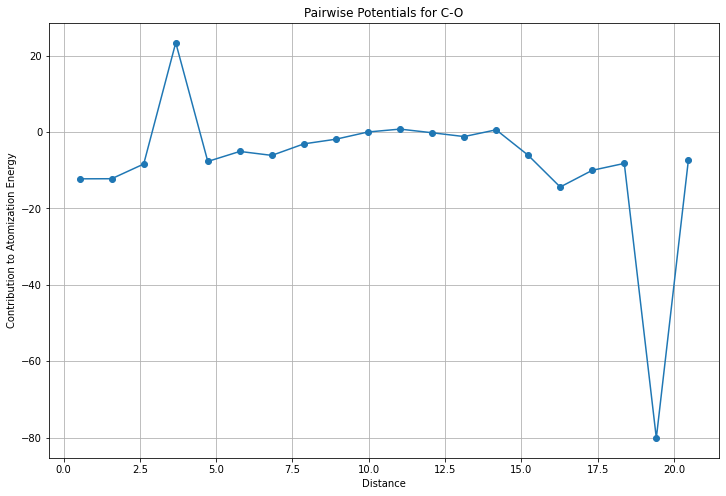

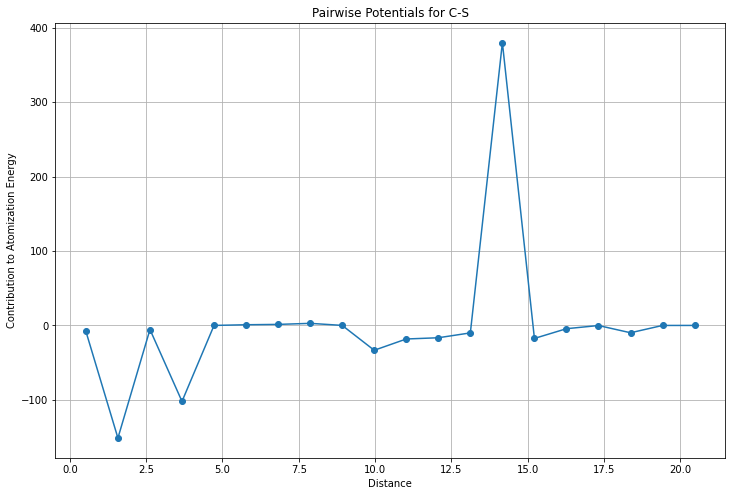

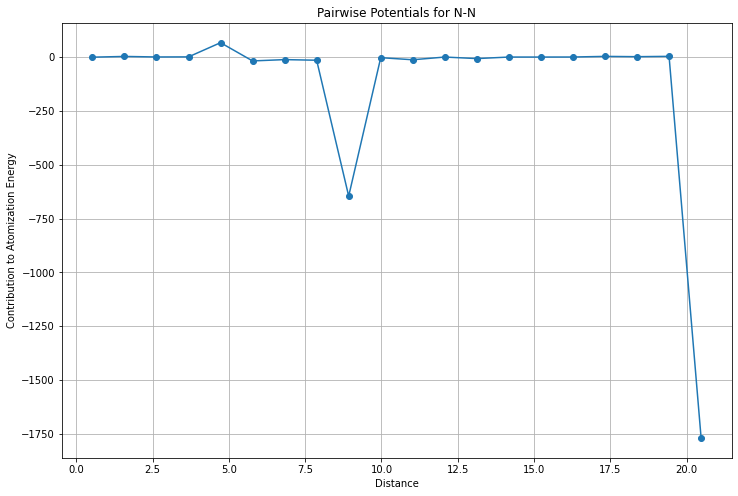

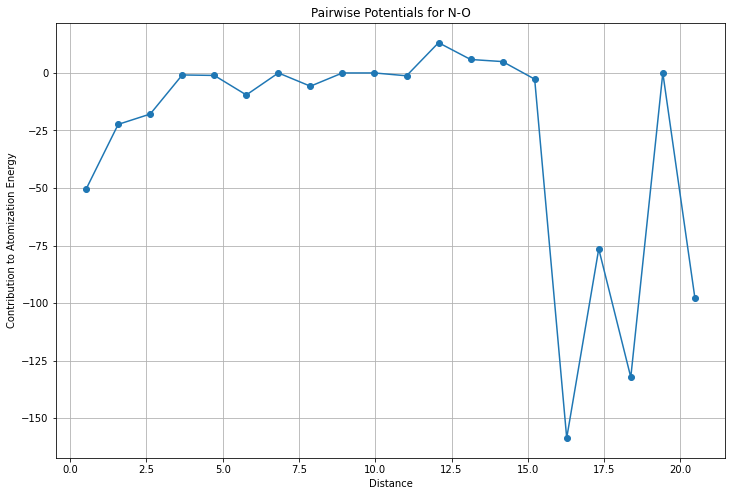

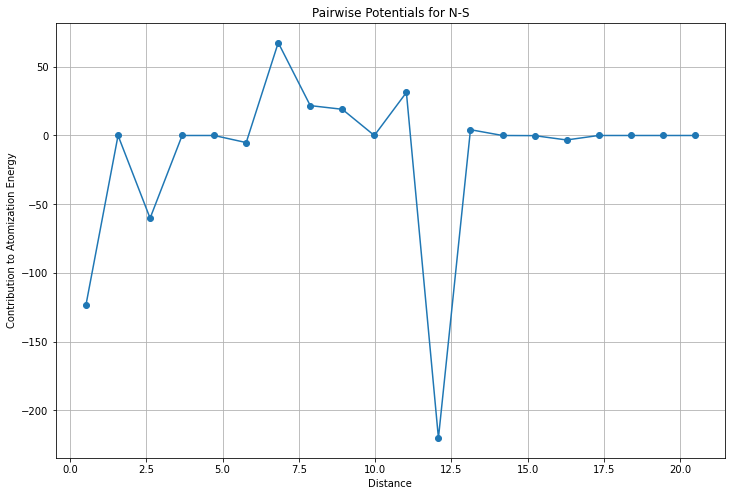

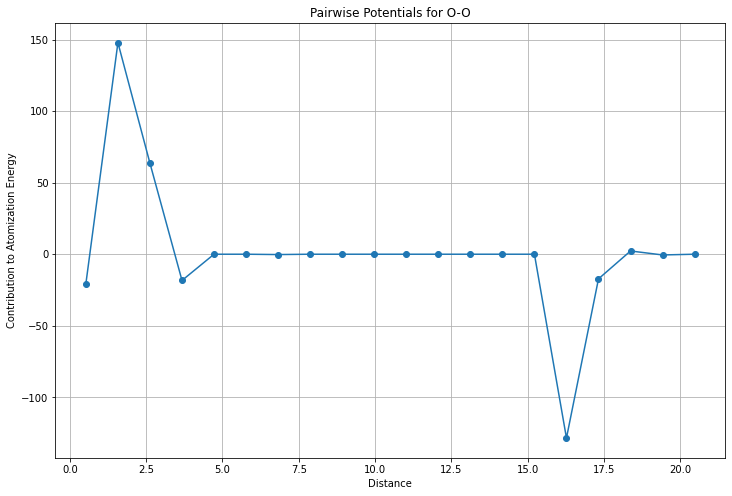

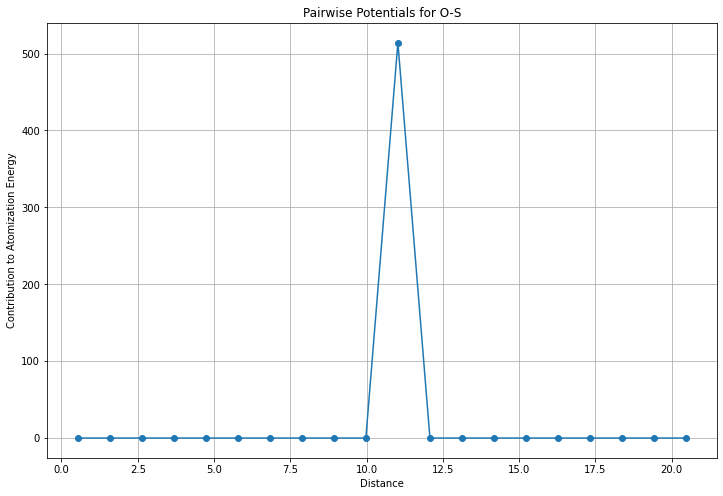

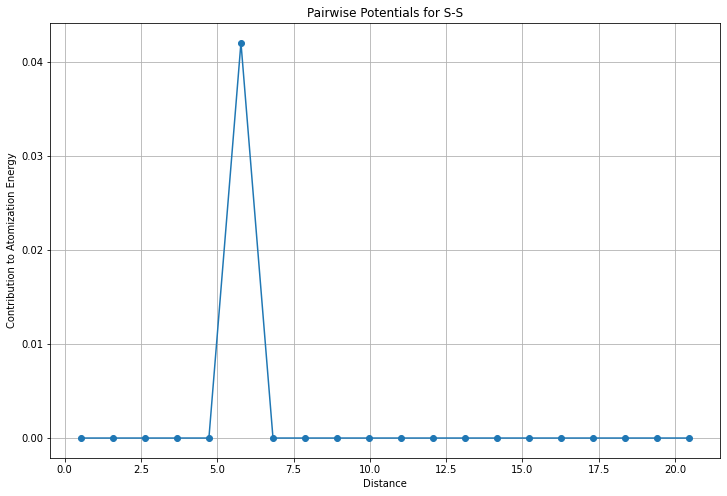

In [70]:
# Plot pairwise potentials for each unique pair
plot_pairwise_potentials(w, bin_centers)

The plot shows weights for the different bins of distances for each atom pair. We can observe that the weights for some pairs show significant peaks for certain distances. We will investigate this phenemenom further in the following analysis.

In [71]:
# Combine distance and atom type features
def representation_pairs(pair, distance, bin_centers, sigma):
    an1, an2 = pair
    el_feature_map = atom_type_fmap(an1, an2)
    dist_feature_map = distance_fmap_soft(distance, bin_centers, sigma)
    feature_map_pair = np.outer(dist_feature_map, el_feature_map).flatten()
    return feature_map_pair

# Predict contribution for a pair at a specific distance
def get_prediction_pair(pair, distance, coef, X_train_val_mean, Y_train_val_mean, bin_centers, sigma):
    feature_map = representation_pairs(pair, distance, bin_centers, sigma)
    prediction = coef.dot(feature_map) 
    return prediction

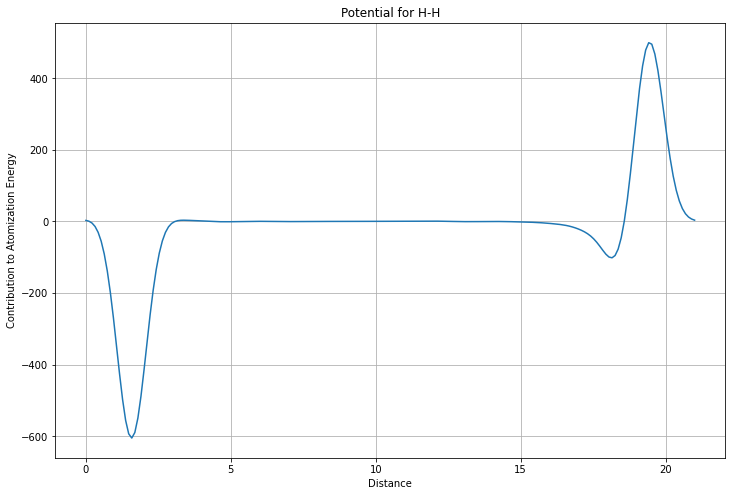

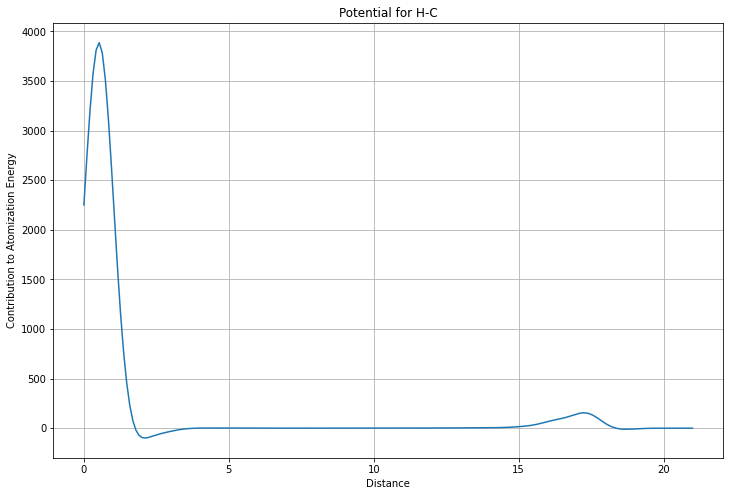

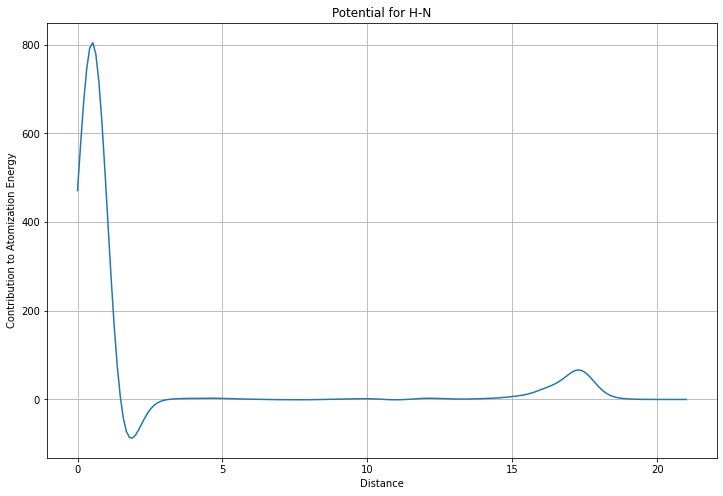

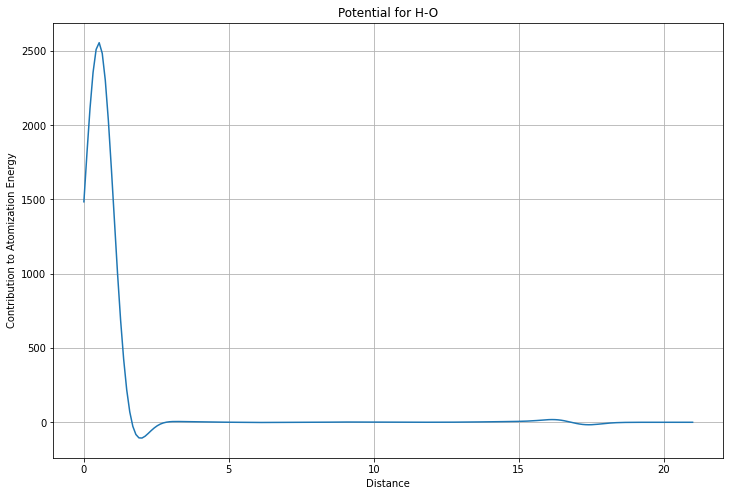

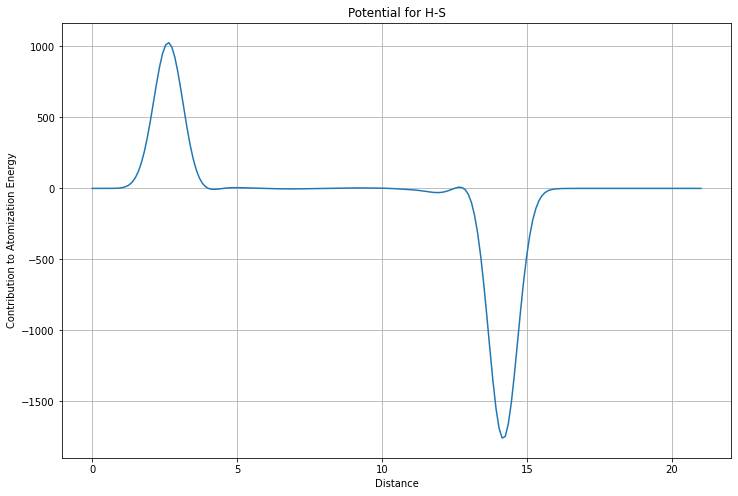

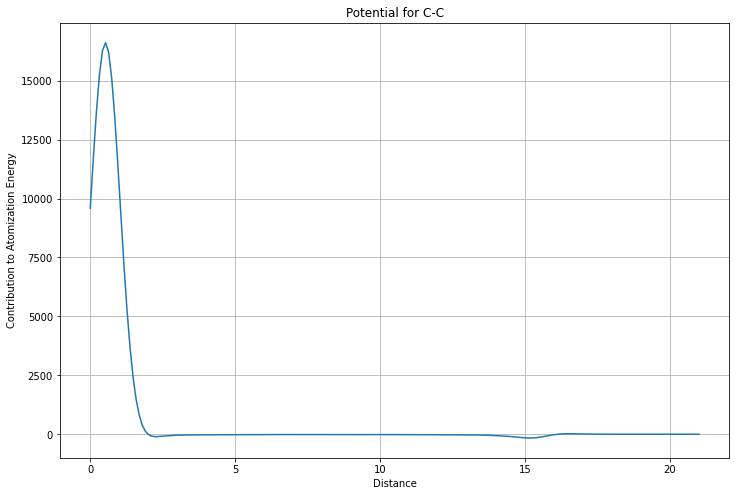

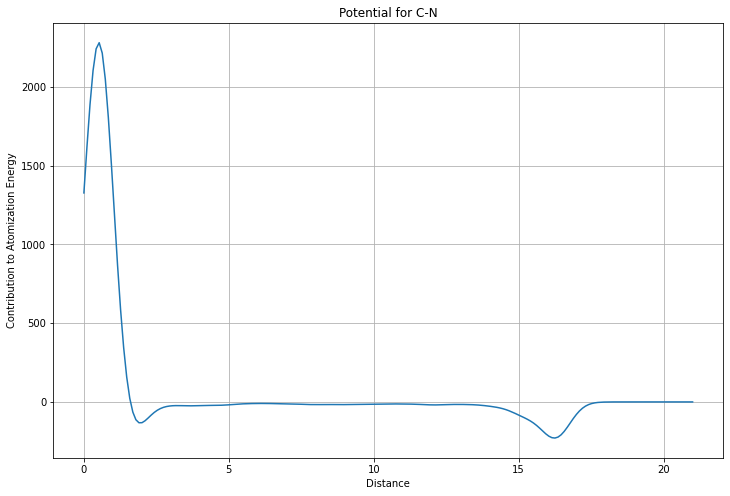

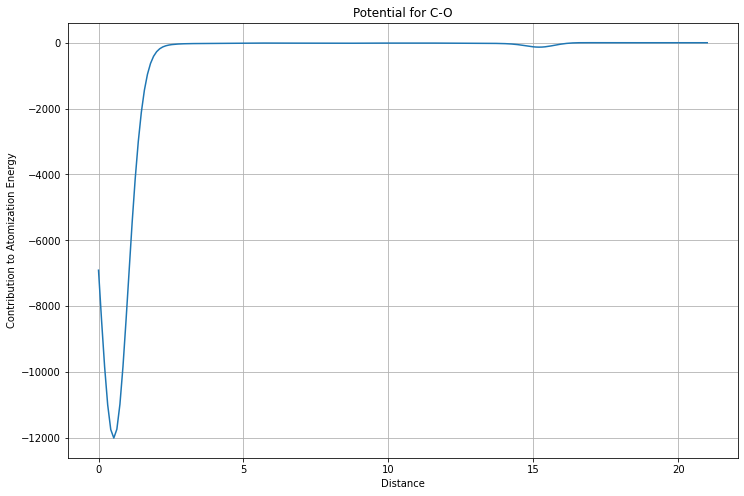

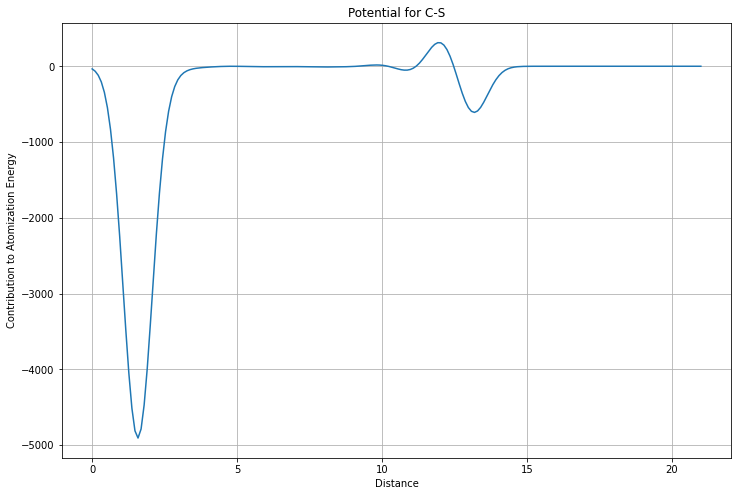

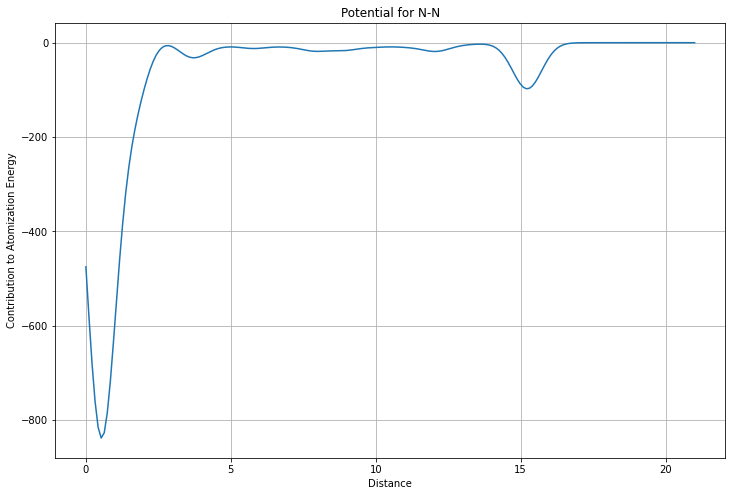

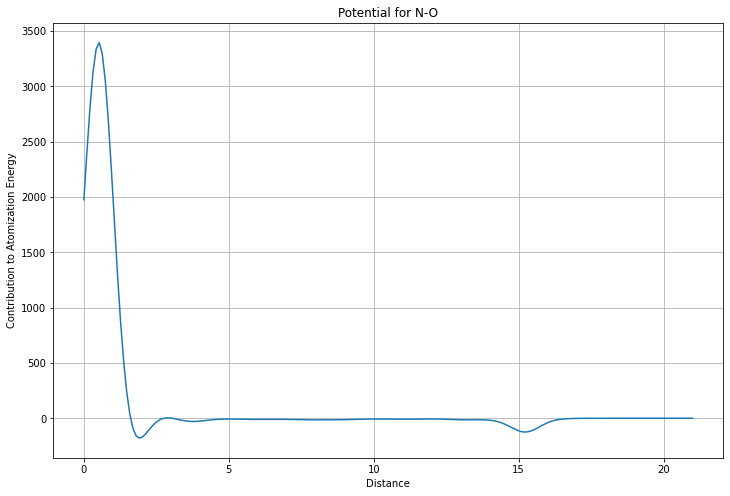

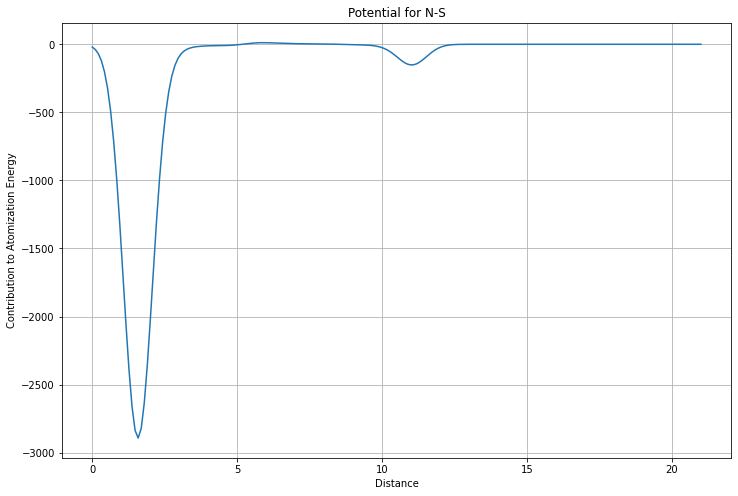

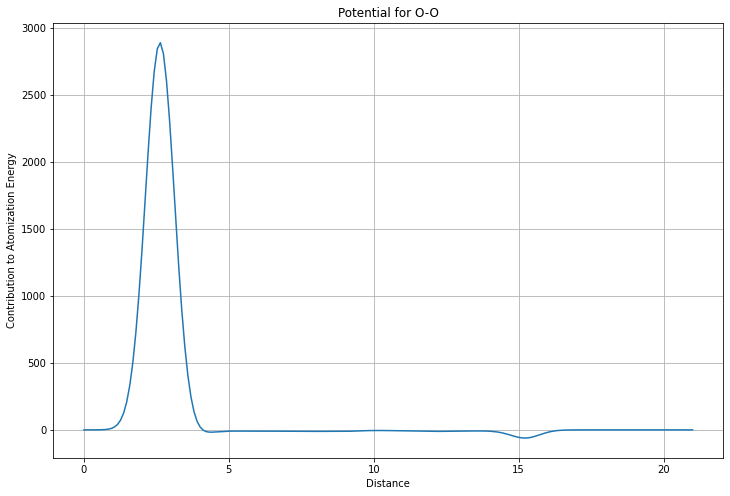

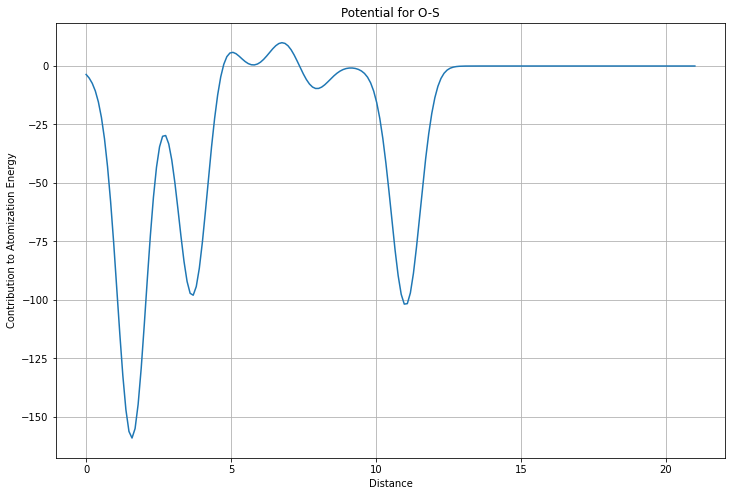

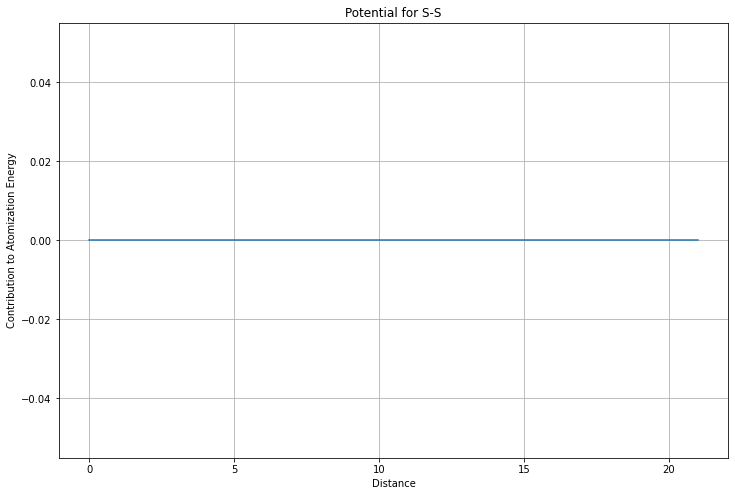

In [72]:
dist = np.linspace(min_dist, max_dist, 200)

# Plotting pairwise potentials
for pair in unique_pairs:
    potentials = [get_prediction_pair(pair, d, w2, X_train_val_mean2, y_train_val_mean2, bin_centers, best_sigma) for d in dist]
    plt.figure(figsize=(12, 8))
    plt.plot(dist, potentials)
    plt.xlabel('Distance')
    plt.ylabel('Contribution to Atomization Energy')
    plt.title(f'Potential for {atomic_symbols[pair[0]]}-{atomic_symbols[pair[1]]}')
    plt.grid(True)
    plt.show()

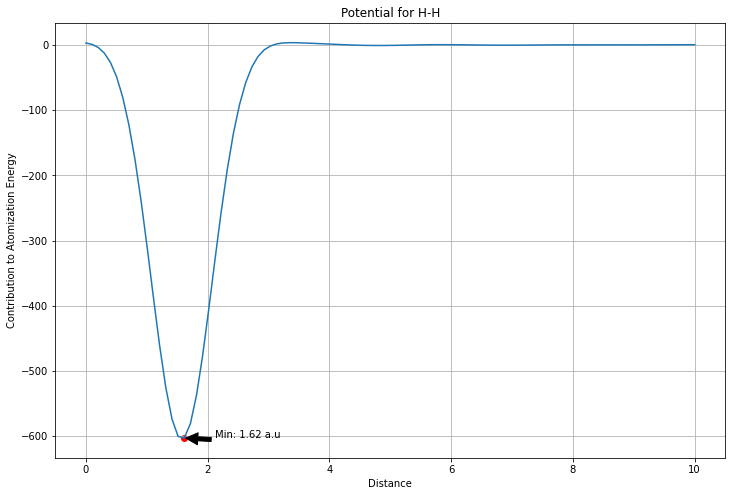

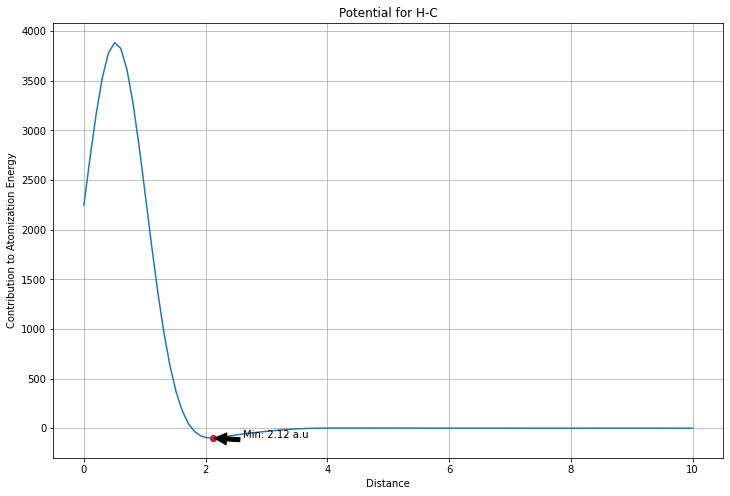

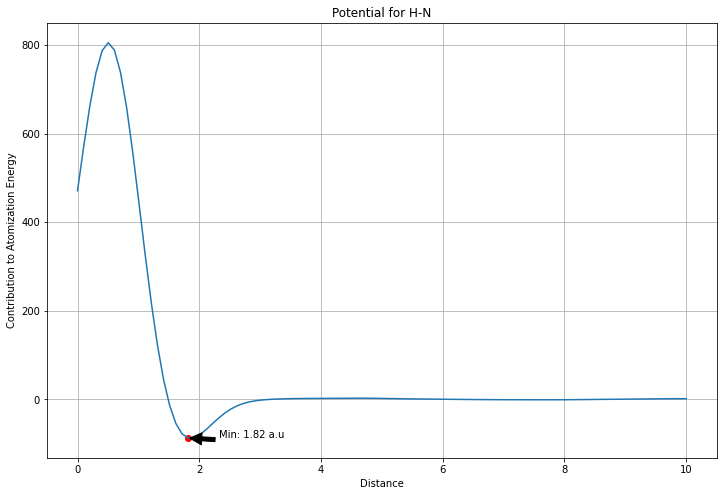

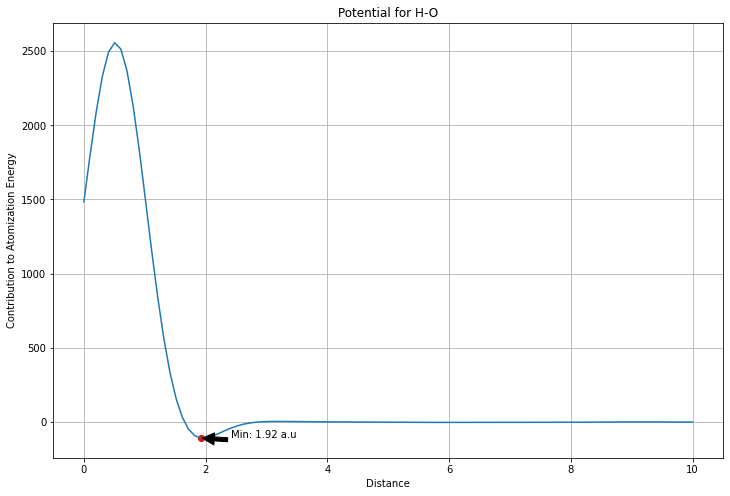

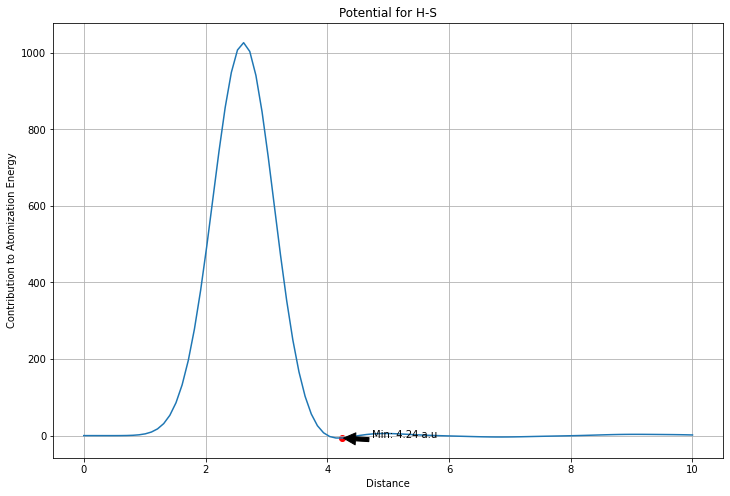

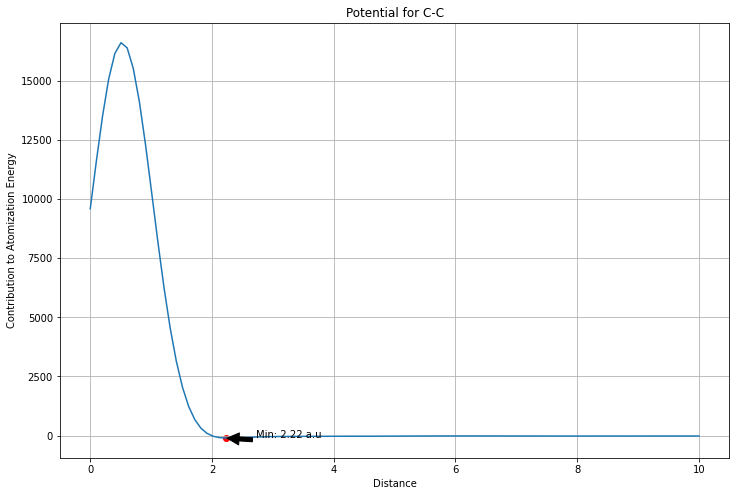

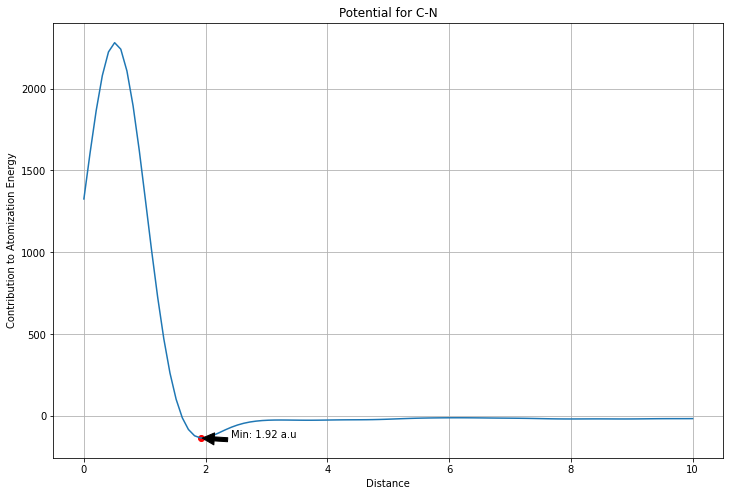

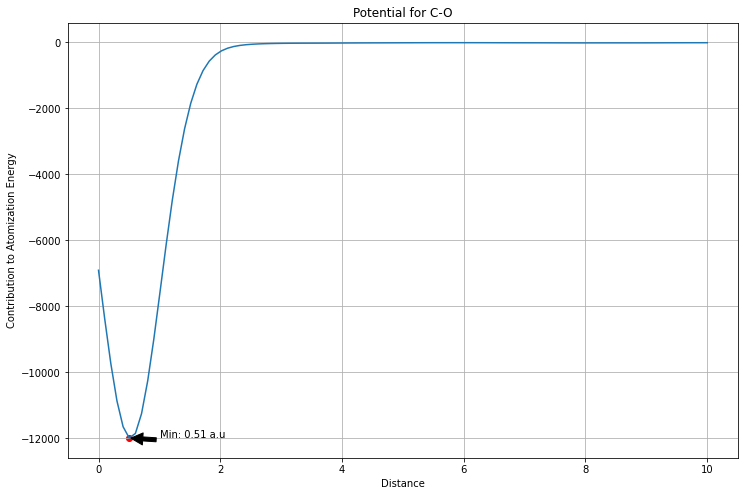

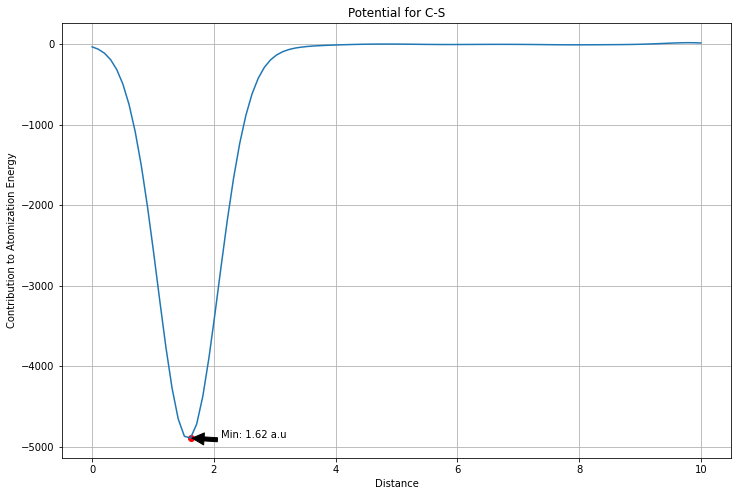

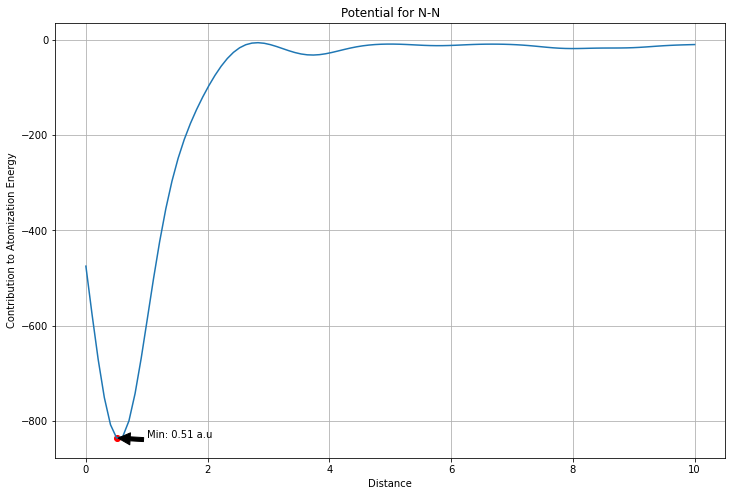

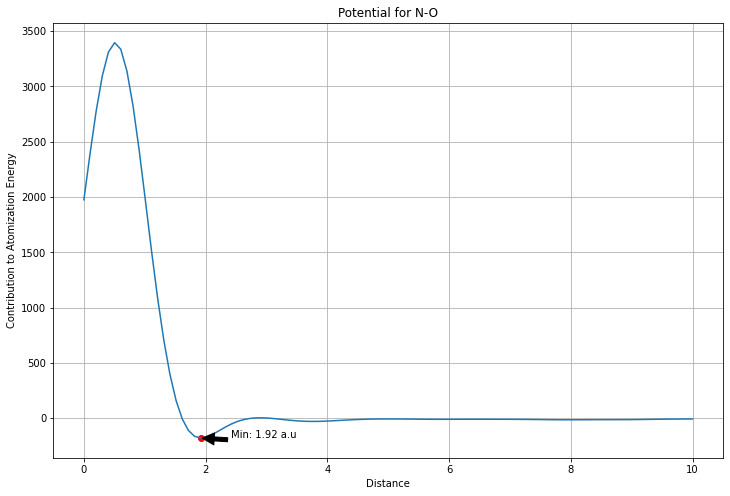

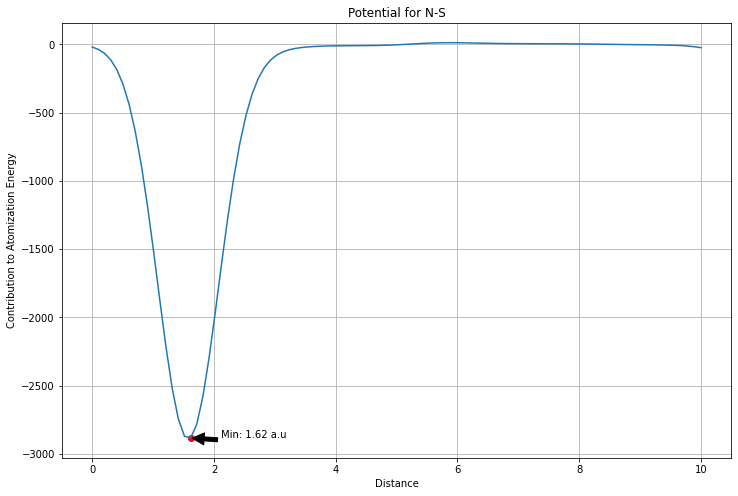

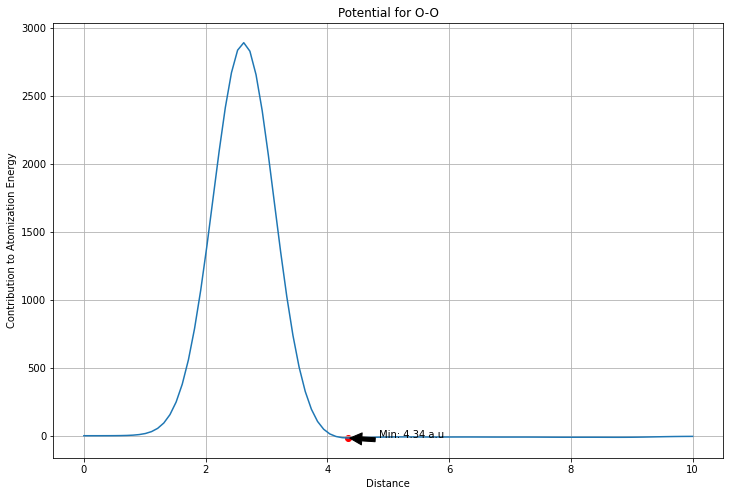

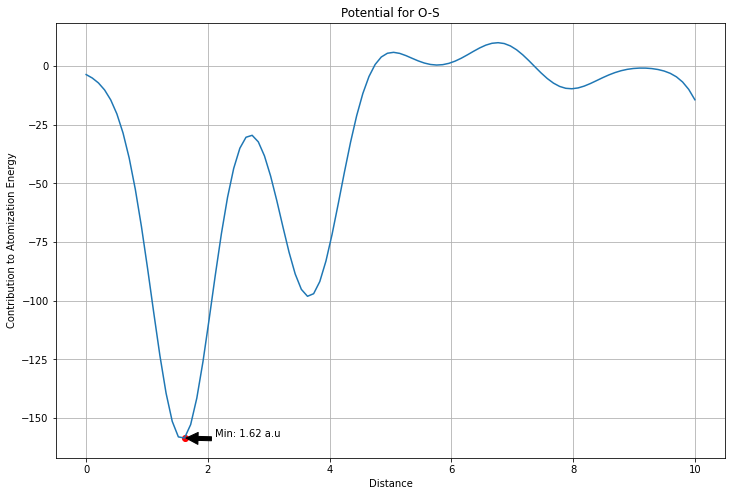

In [73]:
dist = np.linspace(min_dist, 10, 100)

# Plotting pairwise potentials
for pair in unique_pairs[:-1]:
    potentials = [get_prediction_pair(pair, d, w2, X_train_val_mean2, y_train_val_mean2, bin_centers, best_sigma) for d in dist]
    min_contribution_idx = np.argmin(potentials)
    min_contribution_distance = dist[min_contribution_idx]
    min_contribution_value = potentials[min_contribution_idx]
    
    plt.figure(figsize=(12, 8))
    plt.plot(dist, potentials)
    plt.scatter([min_contribution_distance], [min_contribution_value], color='red')  # Mark the minimum point
    plt.annotate(f'Min: {min_contribution_distance:.2f} a.u',
                 xy=(min_contribution_distance, min_contribution_value),
                 xytext=(min_contribution_distance + 0.5, min_contribution_value + 0.5),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.xlabel('Distance')
    plt.ylabel('Contribution to Atomization Energy')
    plt.title(f'Potential for {atomic_symbols[pair[0]]}-{atomic_symbols[pair[1]]}')
    plt.grid(True)
    plt.show()

**Comparison with chemical knowlesge**

The graphs above show the contribution to the atomization energy for each pair of atoms with respect to their bond length. Since the atomization energy consists of the different bond energies within the molecule, a chemically explainable model should assign a very high contribution to the atomization energy for the typical bond length of a pair of atoms, and a relatively low contribution for any other distance. To facilitate comparison, arrows in the last set of diagrams indicate the global minima (as the energies are denoted as negative). The following table shows the typical bond lengths for single bonds in atomic units.

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
 & \textbf{C} & \textbf{H} & \textbf{N} & \textbf{O} & \textbf{S} \\ \hline\hline
\textbf{C} & 2.87 & 2.04 & 2.78 & 2.70 & 3.44 \\ \hline
\textbf{H} & 2.04 & 1.40 & 1.91 & 1.83 & 2.53 \\ \hline
\textbf{N} & 2.78 & 1.91 & 2.76 & 2.57 & 3.31 \\ \hline
\textbf{O} & 2.70 & 1.83 & 2.57 & 2.80 & 3.04 \\ \hline
\textbf{S} & 3.44 & 2.53 & 3.31 & 3.04 & 3.87 \\ \hline
\end{array}
$$

Comparing the table with the global minima of the graphs, we can observe several correspondences. For example, for the H-H pair, the model assigns the highest contribution at a length of 1.62 AU, whereas the typical bond length for two hydrogen atoms is 1.40 AU. Similarly, we see correspondences for the pairs C-H, H-N, H-O, and C-C. For the bonds H-S, C-O, C-S, C-N, N-N, N-O, O-O, and O-S, the trajectory of the graph is not explainable by typical single bond lengths, and there are two minima for O-S.

Again, the occurrences of multiple bonds should be considered. The corresponding bond lengths are shown below.

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
 \textbf{C=C} & \textbf{C} \equiv \textbf{C} & \textbf{O=O} & \textbf{O=C} & \textbf{C} \equiv \textbf{O} 
 & \textbf{N=N} & \textbf{N} \equiv \textbf{N} & \textbf{C}  \equiv \textbf{N} & \textbf{C=N} \\ \hline
2.53 & 2.27 & 2.29 & 2.29 & 2.14   & 2.31 & 2.14 & 2.17 & 2.40 \\ \hline
\end{array}
$$

From the second length table, we can derive that the average bond lengths for the pairs C-O, N-N, C-N, and O-O are actually smaller because they often occur with multiple bonds. Consequently, it is not possible to chemically deduce a specific length where the contribution for these pairs is higher. Another effect that influences the atomization energy is the existence of different polarizations within the molecule, which lead to shorter bond lengths and higher bond energies for the bonds between the polarized groups. As our model considers all pairs of atoms in a molecule without accounting for whether there is an actual bond between them, it can result in two atoms from typically different polarized groups showing a higher contribution at a greater distance, such as for the pair O-S.

Overall, the model that accounts for pairs of atoms and their distances more accurately reflects the chemical reasoning behind bond energies that sum up to the atomization energy than the previous model. Additionally, we observed that for certain bonds, the XAI (Explainable AI) of the models shows that the pair contributed most at its bond length. However, some of the contributions of the pairs could not be easily understood chemically. Therefore, this behavior of the model should be further investigated.

Sources for chemical background:

    - https://www.internetchemie.info/chemie-lexikon/daten/b/bindungslaengen.php
    
    - https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Chemical_Bonding/Fundamentals_of_Chemical_Bonding/Bond_Energies